In [1]:
import functions as fct
import pandas as pd
import dynamics as dyn
import numpy as np
import dask
from cluster import new_launch_cluster
import graphics as gx

path = "./results/parameter_space/test/"

dic_default_value = {
    "nb_banks": 50,
    "initial_deposits_size": 1e-5,
    "alpha_init": False,
    "alpha": 0.01,
    "beta_init": 0.5,
    "beta_reg": 0.5,
    "beta_star": 0.5,
    "beta_new": 0.5,
    "gamma_init": 0.03*10,
    "gamma": 0.03,
    "gamma_star": 0.03*10, 
    "gamma_new": 0.03*10, 
    "collateral_value": 1.0,
    "initialization_method": "pareto",
    "alpha_pareto": 1.3,
    "shocks_method": "non-conservative",
    "shocks_law": "normal-mean-reverting",
    "shocks_vol": 0.01,
    "LCR_mgt_opt": True,
    "min_repo_trans_size": 1e-8,
    "loan_tenor": 5000, # for money creation 
    "loan_period":1,
    "new_loans_vol":0,
    "new_loans_mean":1000000e-2/250,
    "end_repo_period":False,
    "nb_steps": int(5e3),
    "path_results": f"{path}runs/",
    "dump_period": int(5e3),
    "plot_period": int(1e2),
    "cp_option": True,
    "heavy_plot": False,  # False to avoid the number of linux node to explode
}

# special dictionary of parameters ranges 
dic_range_special = {
    # "nb_banks": np.arange(155, 260, 5),  # 10 to 260
    # "initial_deposits_size": np.logspace(-5, 3, num=500),
    # "initial_deposits_size": [1e-5 for _ in range(500)],
    # "alpha_init": np.arange(0, 0.3, 0.01),
    # "beta_init": np.arange(0, 1, 0.02),
    # "beta_reg": np.arange(0.01, 1, 0.01),
    # "alpha_pareto": np.logspace(0, 1, num=50),
    "shocks_vol": np.arange(0, 0.30, 0.0010),
    # "min_repo_trans_size": np.logspace(-16, 2, num=50),
}

# general dictionary of parameters ranges
dic_range_general = {
    "nb_banks": np.arange(1, 3),
    "initial_deposits_size": np.logspace(-9, 3, num=50),
    "alpha_init": np.arange(0, 1, 0.1),
    "beta_init": np.arange(0, 1, 0.05),
    "beta_reg": np.arange(0.01, 0.03, 0.01),
    "alpha_pareto": np.logspace(0, 1, num=3),
    "shocks_vol": np.arange(0, 0.30, 0.0025),
    "min_repo_trans_size": np.logspace(-16, 2, num=3),
}

# define the dictionary to be used for the ranges
dic_range = dic_range_special

# run parameter space analysis

In [2]:
# initialize the path
# fct.delete_n_init_path(path)

# build list of the dic_args to be tested
list_dic_args = fct.build_args(dic_default_value, dic_range)

# open a cluster
client, cluster = new_launch_cluster(
    task_memory=19,
    job_walltime="2:00:00",
    max_cpu=fct.get_nb_runs(dic_range),
)

# run with dask distributed
dld_obj = [
    dask.delayed(dyn.single_run)(**dic_args) for dic_args in list_dic_args
]
futures = client.compute(dld_obj)


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.70.211.9:8787/status,
Dashboard: http://10.70.211.9:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.70.211.9:39986,Workers: 0
Dashboard: http://10.70.211.9:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
for i, future in enumerate(futures):
    if future.status == "finished":
        print(i, future.result())

In [5]:
np.arange(0, 0.30, 0.0010)[25]

0.025

In [6]:
client.shutdown()

In [ ]:
dyn.single_run(*dic_default_value.values())

# collect results

In [8]:
# collect results into df_network_sensitivity
df_network_sensitivity = fct.get_df_network_sensitivity(dic_default_value["path_results"])

100%|██████████| 2/2 [01:20<00:00, 40.24s/it]


<AxesSubplot: >

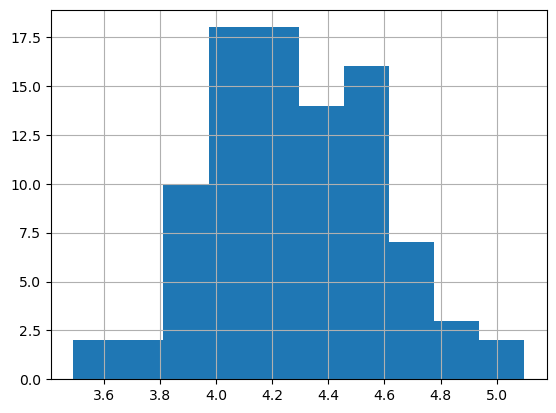

In [5]:
(df_network_sensitivity["borrowings ov. deposits tot. network"]).hist()

<AxesSubplot: >

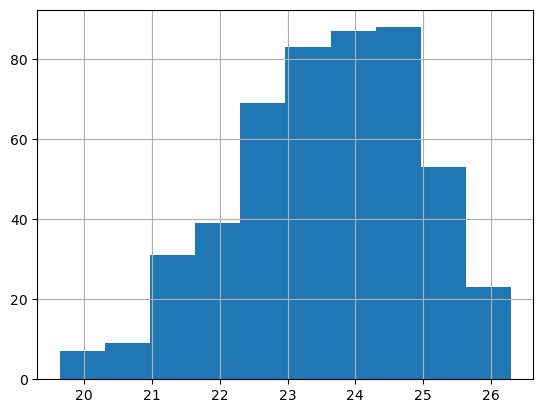

In [5]:
(df_network_sensitivity["own funds tot. network"]/df_network_sensitivity["total assets tot. network"]*100).hist()

<AxesSubplot: >

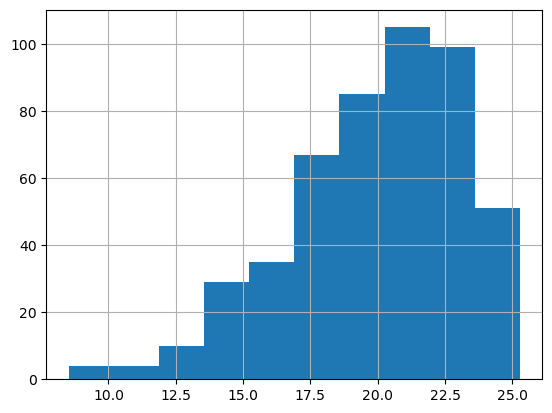

In [6]:
df_network_sensitivity["leverage ratio av. network"].hist()

# plot results

In [2]:
# plot the sensitivity
df_network_sensitivity = pd.read_csv(f"{dic_default_value['path_results']}df_network_sensitivity.csv", index_col=(0,1))
gx.plot_all_sensitivities(df_network_sensitivity,path=path)

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:11<00:00,  1.59it/s]
